In [1]:
import os
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss, coint, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib
from arch.unitroot import PhillipsPerron
from typing import List

In [2]:
FIRST_SLICE_DATE: datetime = datetime.strptime('27/10/2018', '%d/%m/%Y')
SECOND_SLICE_DATE: datetime = datetime.strptime('1/5/2020', '%d/%m/%Y')

In [3]:
def transform_date_series(df: pd.DataFrame, date_key: str) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, date_key] = pd.to_datetime(dff.loc[:, date_key], unit='s')
    
    return dff.set_index(date_key)

In [4]:
def filter_series(df: pd.DataFrame, slice1: datetime, slice2: datetime) -> pd.DataFrame:
    dff: pd.DataFrame = df.copy()
    dff.loc[:, :] = dff[dff.index > slice1]
    dff.loc[:, :] = dff[dff.index < slice2]

    return dff.dropna()

In [5]:
def print_adf(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    adf_test = adfuller(series, autolag='AIC')
    p_value = adf_test[1]

    dfResults = pd.Series(adf_test[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    #Add Critical Values
    for key,value in adf_test[4].items():
        dfResults[f'Critical Value ({key})'] = value

    print('Augmented Dickey-Fuller Test Results:')
    print(dfResults)

In [6]:
def print_kpss(df: pd.DataFrame, key: str) -> None:
    series = df.loc[:, key].values

    statistic, p_value, n_lags, critical_gasValue = kpss(series, nlags="auto", regression='c')
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')

    for key, value in critical_gasValue.items():
        print(f'   {key} : {value}')

# GAS series

Loading and cleaning gas data.

In [7]:
gas: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'avg_gas_price.csv'), header=0)
gas.rename(columns={'UnixTimeStamp': 'date', 'Value (Wei)': 'gasValue'}, inplace = True)
gas = gas[['date', 'gasValue']].dropna()
gas = transform_date_series(df=gas, date_key='date')

## Original series

Let's see how the series looks like.

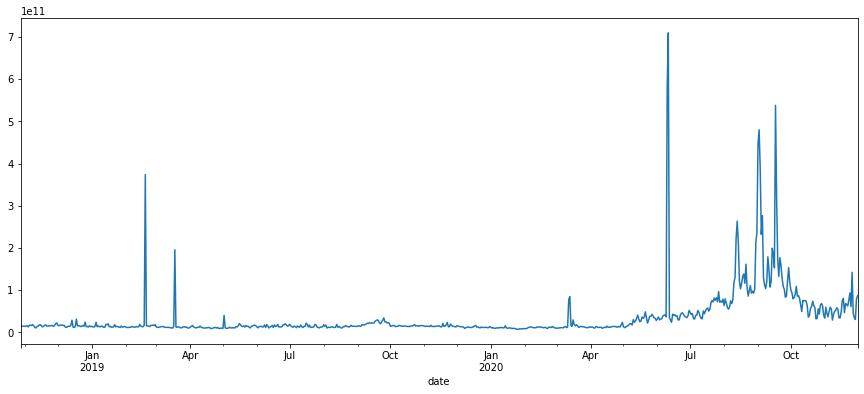

In [8]:
gas_plot = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=datetime.today())
gas_plot['gasValue'].plot(figsize = (15, 6))
plt.show()

## Splitting the series

We can see there is two-stage in the series. The first stage ends around May first of 2020, from then the series changed. So let's split the series into two slices.

In [9]:
gas_slice1 = filter_series(df=gas, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
gas_slice1['gasValue'] = np.log(gas_slice1['gasValue'] / gas_slice1['gasValue'].shift(1))
gas_slice1.dropna(inplace=True)

In [10]:
gas_slice2 = filter_series(df=gas, slice1=SECOND_SLICE_DATE, slice2=datetime.now())
gas_slice2['gasValue'] = np.log(gas_slice2['gasValue'] / gas_slice2['gasValue'].shift(1))
gas_slice2.dropna(inplace=True)

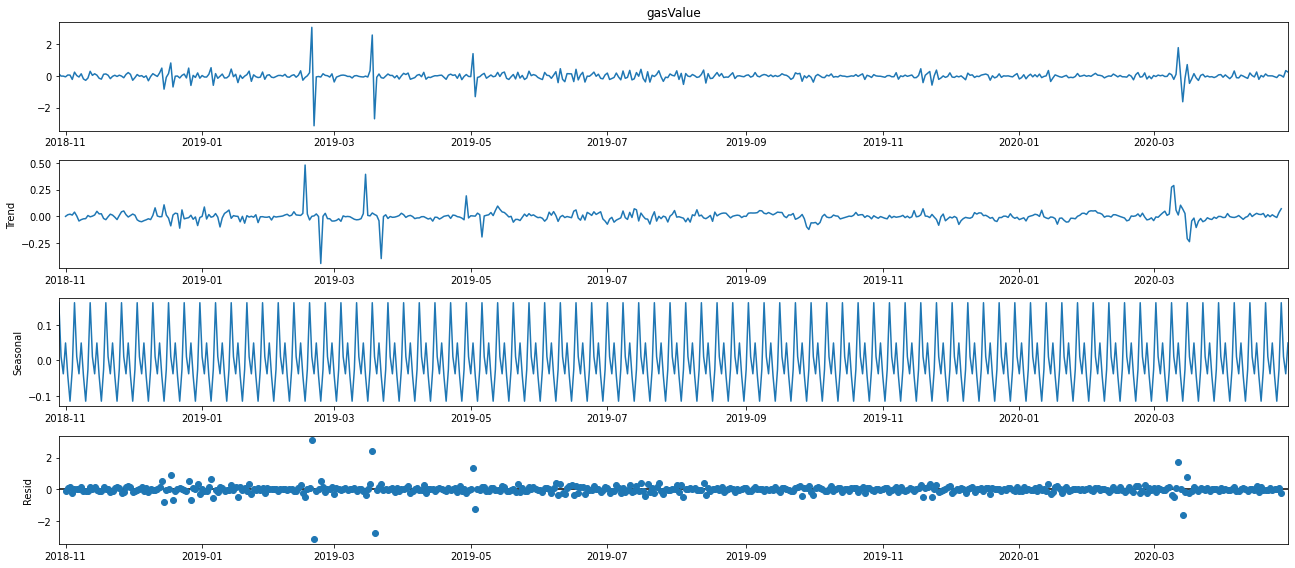

In [11]:
rcParams['figure.figsize'] = 18, 8
decomposition1 = sm.tsa.seasonal_decompose(x=gas_slice1['gasValue'], model='additive')
fig = decomposition1.plot()
plt.show()

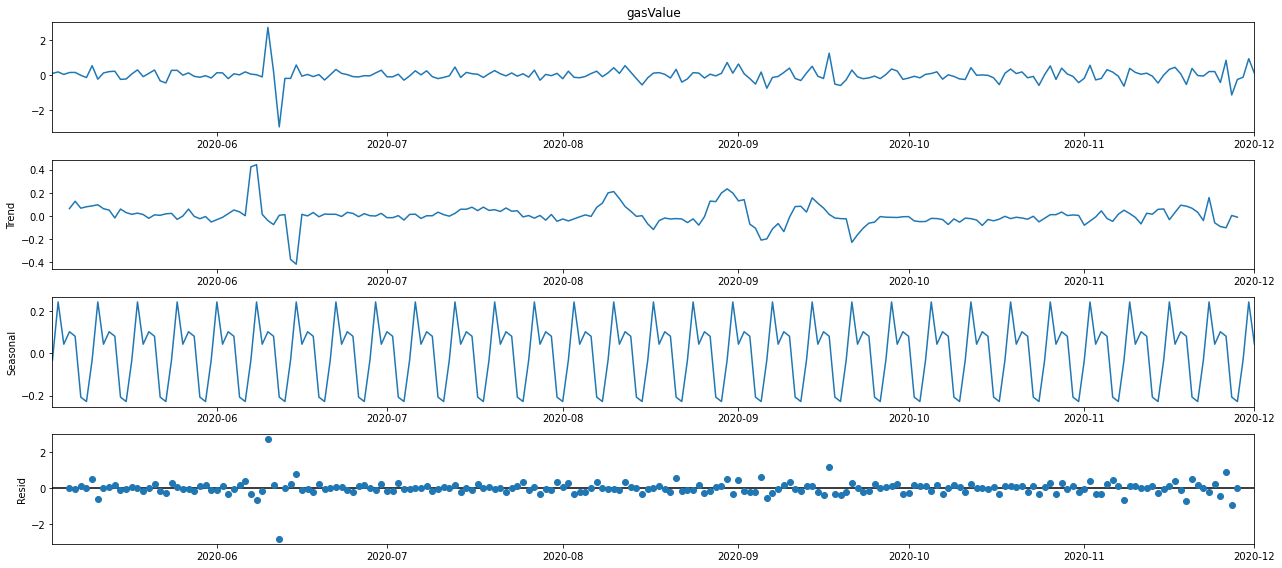

In [12]:
rcParams['figure.figsize'] = 18, 8
decomposition2 = sm.tsa.seasonal_decompose(x=gas_slice2['gasValue'], model='additive')
fig = decomposition2.plot()
plt.show()

In [13]:
gas_slice1['gasValue'] = gas_slice1['gasValue'] - decomposition1.seasonal

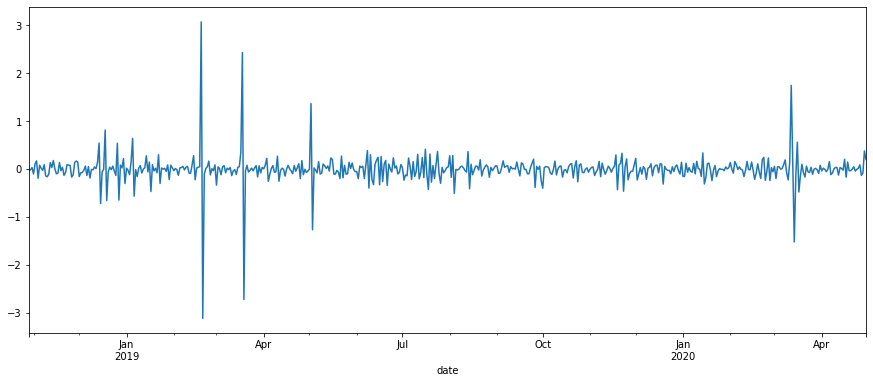

In [14]:
gas_slice1['gasValue'].plot(figsize = (15, 6))
plt.show()

In [15]:
gas_slice2['gasValue'] = gas_slice2['gasValue'] - decomposition2.seasonal

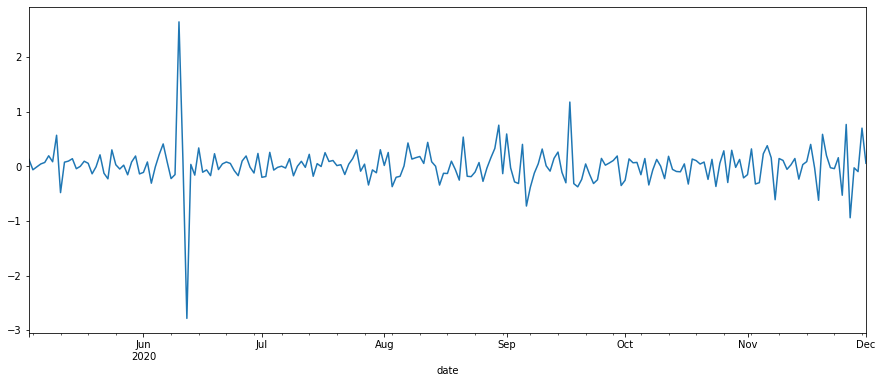

In [16]:
gas_slice2['gasValue'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [17]:
print_adf(df=gas_slice1, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.231118e+01
P-Value                 7.086147e-23
# Lags Used             7.000000e+00
# Observations Used     5.420000e+02
Critical Value (1%)    -3.442473e+00
Critical Value (5%)    -2.866887e+00
Critical Value (10%)   -2.569618e+00
dtype: float64


In [18]:
print_adf(df=gas_slice2, key='gasValue')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.178844e+01
P-Value                 9.958375e-22
# Lags Used             2.000000e+00
# Observations Used     2.100000e+02
Critical Value (1%)    -3.461879e+00
Critical Value (5%)    -2.875404e+00
Critical Value (10%)   -2.574159e+00
dtype: float64


## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [19]:
print_kpss(df=gas_slice1, key='gasValue')

KPSS Statistic: 0.1390942813204136
p-value: 0.1
num lags: 111
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [20]:
print_kpss(df=gas_slice2, key='gasValue')

KPSS Statistic: 0.1897524017338137
p-value: 0.1
num lags: 43
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Phillips–Perron (PP) test

Let's test both series with augmented Phillips–Perron test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [21]:
pp = PhillipsPerron(gas_slice1['gasValue'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -66.758
P-value                         0.000
Lags                               19
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [22]:
pp = PhillipsPerron(gas_slice2['gasValue'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -23.177
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# Aragon activity series

Let's check what about the activity series.

In [23]:
aragon: pd.DataFrame = pd.read_csv(os.path.join('..', '..', 'data', 'aragon_activity.csv'), header=0)
aragon = transform_date_series(df=aragon, date_key='date')

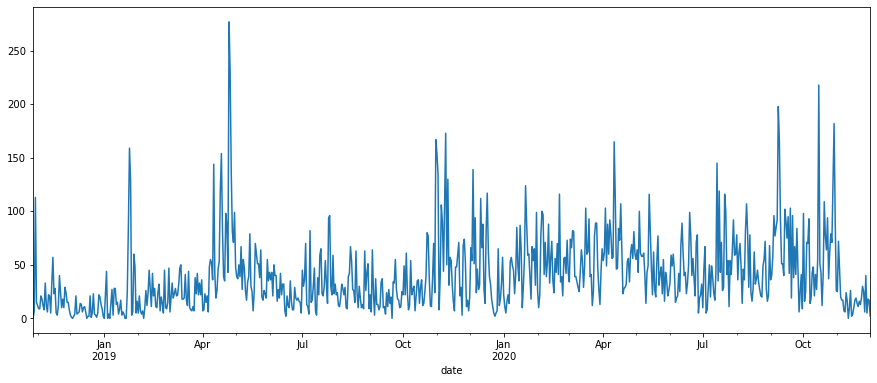

In [24]:
aragon_plot = filter_series(df=aragon, slice1=FIRST_SLICE_DATE, slice2=datetime.today())
aragon_plot['actions'].plot(figsize = (15, 6))
plt.show()

## Spliting the series

As we previously do with the gas series, let's split the series.

In [25]:
aragon_slice1 = filter_series(df=aragon, slice1=FIRST_SLICE_DATE, slice2=SECOND_SLICE_DATE)
aragon_slice1.drop(aragon_slice1.index[0], inplace=True)

In [26]:
aragon_slice2 = filter_series(df=aragon, slice1=SECOND_SLICE_DATE, slice2=datetime.now())
aragon_slice2.drop(aragon_slice2.index[0], inplace=True)

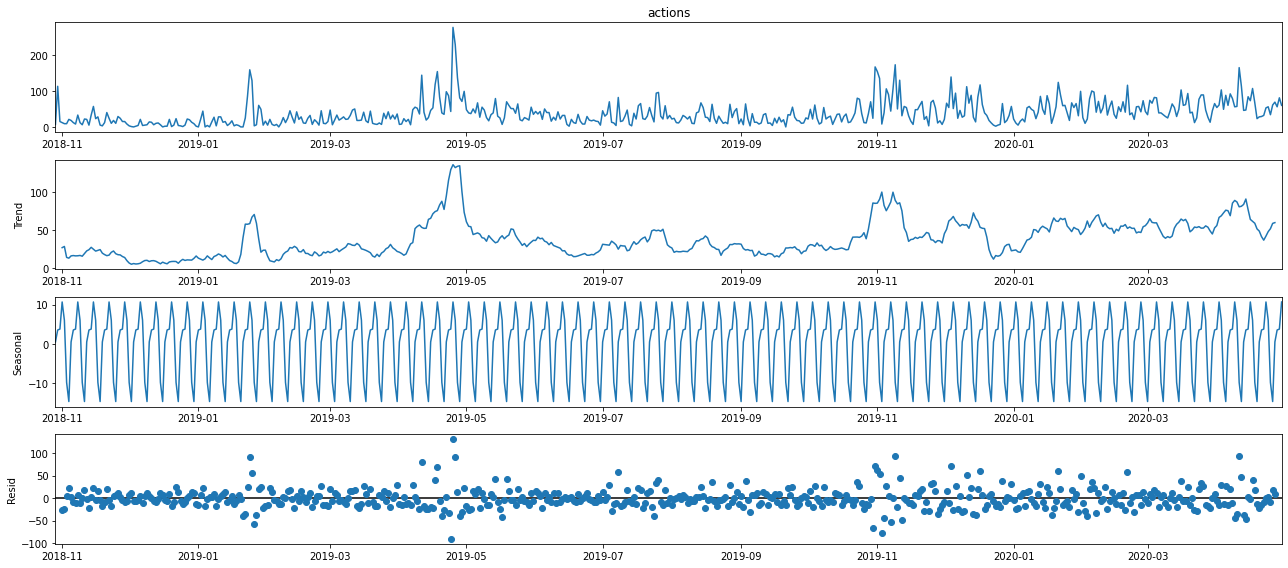

In [27]:
rcParams['figure.figsize'] = 18, 8
decomposition1 = sm.tsa.seasonal_decompose(x=aragon_slice1['actions'], model='additive')
fig = decomposition1.plot()
plt.show()

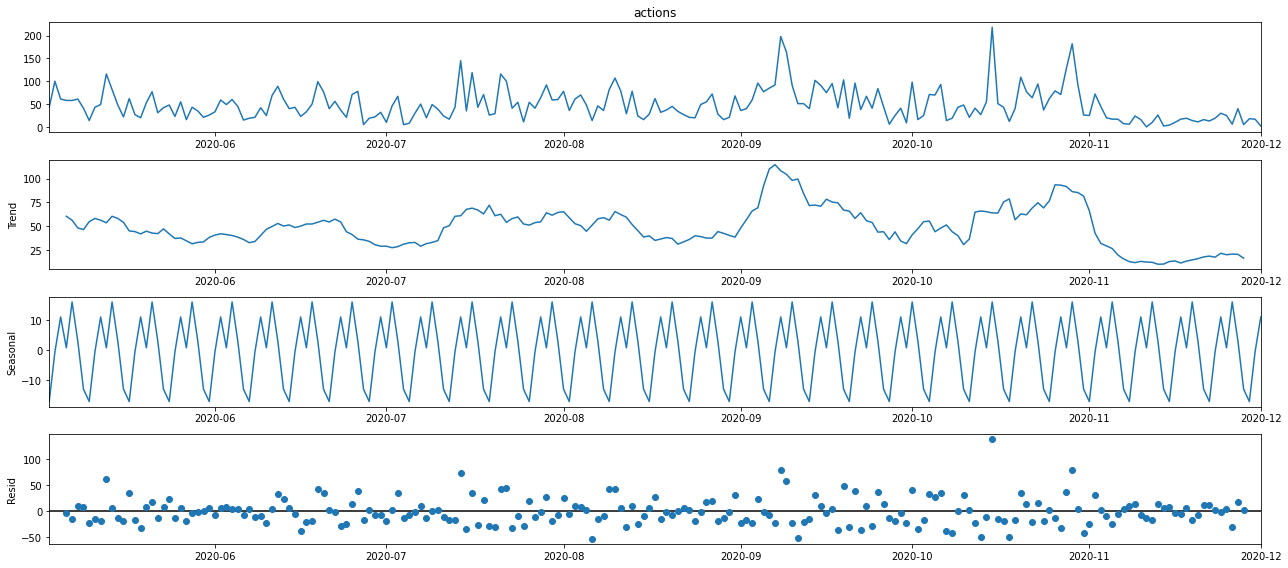

In [28]:
rcParams['figure.figsize'] = 18, 8
decomposition2 = sm.tsa.seasonal_decompose(x=aragon_slice2['actions'], model='additive')
fig = decomposition2.plot()
plt.show()

In [29]:
aragon_slice1['actions'] = aragon_slice1['actions'] - decomposition1.seasonal

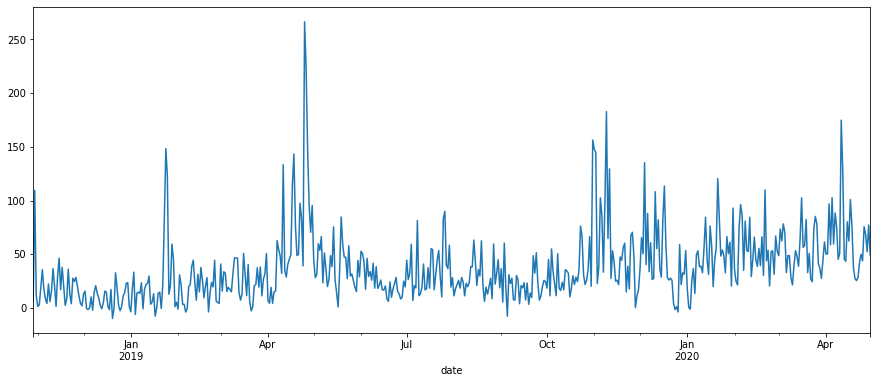

In [30]:
aragon_slice1['actions'].plot(figsize = (15, 6))
plt.show()

In [31]:
aragon_slice2['actions'] = aragon_slice2['actions'] - decomposition2.seasonal

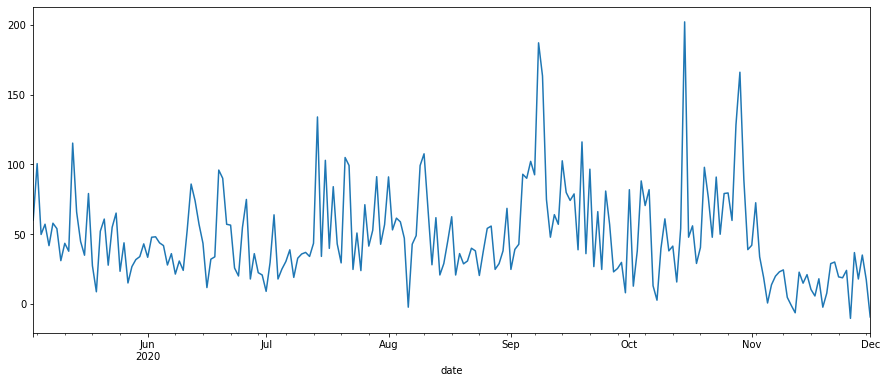

In [32]:
aragon_slice2['actions'].plot(figsize = (15, 6))
plt.show()

## Augmented Dickey-Fuller

Let's test both series with augmented Dickey-Fuller test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [33]:
print_adf(df=aragon_slice1, key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -4.071626
P-Value                   0.001079
# Lags Used               7.000000
# Observations Used     542.000000
Critical Value (1%)      -3.442473
Critical Value (5%)      -2.866887
Critical Value (10%)     -2.569618
dtype: float64


In [34]:
print_adf(df=aragon_slice2, key='actions')

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.766532
P-Value                   0.003269
# Lags Used               4.000000
# Observations Used     208.000000
Critical Value (1%)      -3.462186
Critical Value (5%)      -2.875538
Critical Value (10%)     -2.574231
dtype: float64


## Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test

Where:

    * H0: The process is trend stationary.
    * H1: The series has a unit root (series is not stationary).

In [35]:
print_kpss(df=aragon_slice1, key='actions')

KPSS Statistic: 1.303817878613703
p-value: 0.01
num lags: 13
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1881: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [36]:
print_kpss(df=aragon_slice2, key='actions')

KPSS Statistic: 0.19019755665555918
p-value: 0.1
num lags: 7
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


## Phillips–Perron (PP) test

Let's test both series with augmented Phillips–Perron test.

Where:

    * H0: The series has a unit root (non-stationary).
    * H1: The series has no unit root (stationary).

In [37]:
pp = PhillipsPerron(aragon_slice1['actions'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -16.701
P-value                         0.000
Lags                               19
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [38]:
pp = PhillipsPerron(aragon_slice2['actions'])
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -11.050
P-value                         0.000
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


# Granger Causality Tests

Where:

    * H0: The second column, x2, does NOT Granger cause the time series in the first column, x1
    * H1: x2 Granger cause x1

In [39]:
slice1: pd.DataFrame = pd.DataFrame(
    {'actions': aragon_slice1['actions'].tolist(),
     'gasValue': gas_slice1['gasValue'].tolist(),
    })
    
gc_res1 = grangercausalitytests(slice1, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3984  , p=0.2375  , df_denom=546, df_num=1
ssr based chi2 test:   chi2=1.4061  , p=0.2357  , df=1
likelihood ratio test: chi2=1.4043  , p=0.2360  , df=1
parameter F test:         F=1.3984  , p=0.2375  , df_denom=546, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6070  , p=0.5453  , df_denom=543, df_num=2
ssr based chi2 test:   chi2=1.2252  , p=0.5419  , df=2
likelihood ratio test: chi2=1.2239  , p=0.5423  , df=2
parameter F test:         F=0.6070  , p=0.5453  , df_denom=543, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4131  , p=0.7436  , df_denom=540, df_num=3
ssr based chi2 test:   chi2=1.2554  , p=0.7397  , df=3
likelihood ratio test: chi2=1.2540  , p=0.7401  , df=3
parameter F test:         F=0.4131  , p=0.7436  , df_denom=540, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5494  , p=0.6995  

In [40]:
slice2: pd.DataFrame = pd.DataFrame(
    {'actions': aragon_slice2['actions'].tolist(),
     'gasValue': gas_slice2['gasValue'].tolist(),
    })
    
gc_res2 = grangercausalitytests(slice2, 5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1476  , p=0.7012  , df_denom=209, df_num=1
ssr based chi2 test:   chi2=0.1497  , p=0.6988  , df=1
likelihood ratio test: chi2=0.1497  , p=0.6988  , df=1
parameter F test:         F=0.1476  , p=0.7012  , df_denom=209, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1223  , p=0.8850  , df_denom=206, df_num=2
ssr based chi2 test:   chi2=0.2504  , p=0.8823  , df=2
likelihood ratio test: chi2=0.2503  , p=0.8824  , df=2
parameter F test:         F=0.1223  , p=0.8850  , df_denom=206, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4191  , p=0.7395  , df_denom=203, df_num=3
ssr based chi2 test:   chi2=1.3007  , p=0.7290  , df=3
likelihood ratio test: chi2=1.2966  , p=0.7299  , df=3
parameter F test:         F=0.4191  , p=0.7395  , df_denom=203, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5709  , p=0.6841  

# VAR analysis

## Slice 1

In [41]:
slice1: pd.DataFrame = gas_slice1.copy(deep=True)
slice1['actions'] = aragon_slice1['actions'].tolist()

In [42]:
model1 = VAR(slice1)
model1.select_order(10).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,4.684,4.700,108.2,4.690
1,4.196,4.244,66.42,4.215
2,4.089,4.169,59.71,4.121
3,4.037,4.148,56.63,4.080
4,3.989,4.133*,54.03,4.045*
5,3.991,4.165,54.09,4.059
6,3.996,4.203,54.39,4.077
7,3.974,4.213,53.21,4.067
8,3.967*,4.237,52.80*,4.072
9,3.975,4.277,53.24,4.093


In [43]:
results1 = model1.fit(maxlags=4, ic='bic')
results1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Jan, 2021
Time:                     13:03:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.11279
Nobs:                     546.000    HQIC:                   4.02640
Log likelihood:          -2615.55    FPE:                    53.0352
AIC:                      3.97095    Det(Omega_mle):         51.3291
--------------------------------------------------------------------
Results for equation gasValue
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.006045         0.020836            0.290           0.772
L1.gasValue        -0.615573         0.042604          -14.449           0.000
L1.actions         -0.000135         0.000430           -0.314   

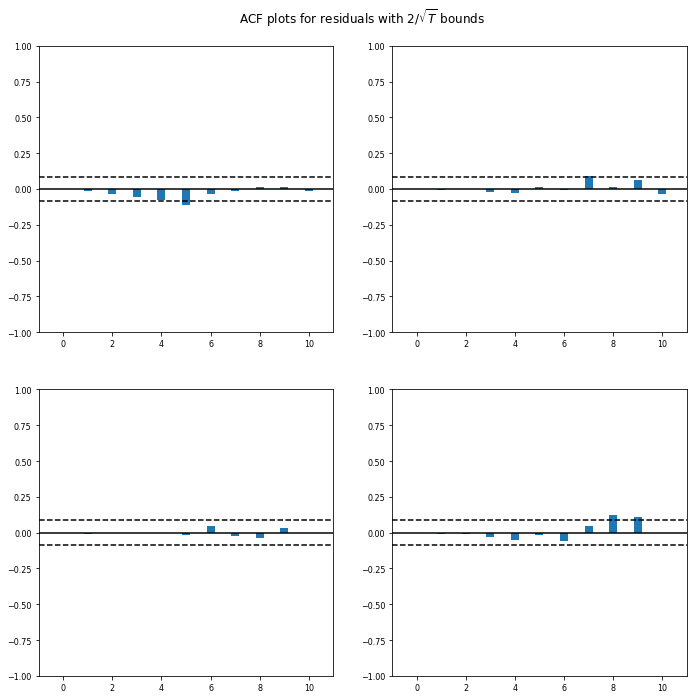

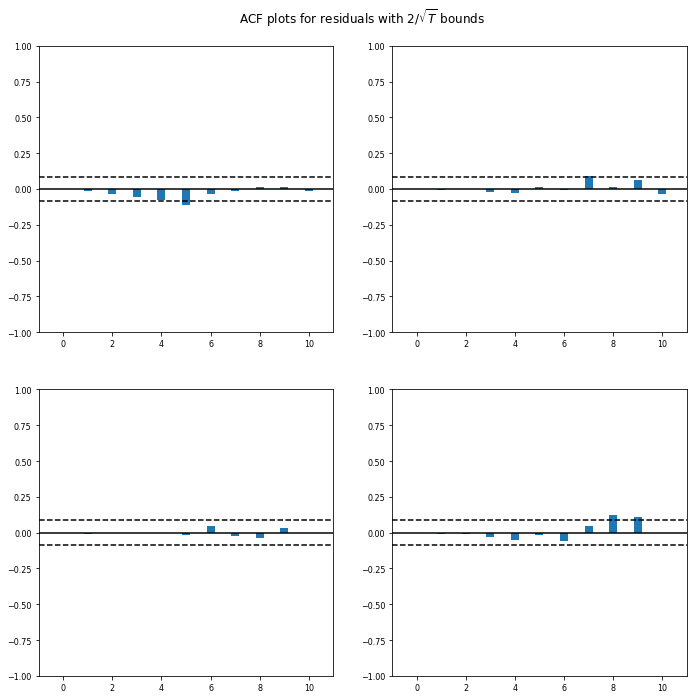

In [44]:
results1.plot_acorr()

### Impulse Response

In [45]:
irf1 = results1.irf(20)

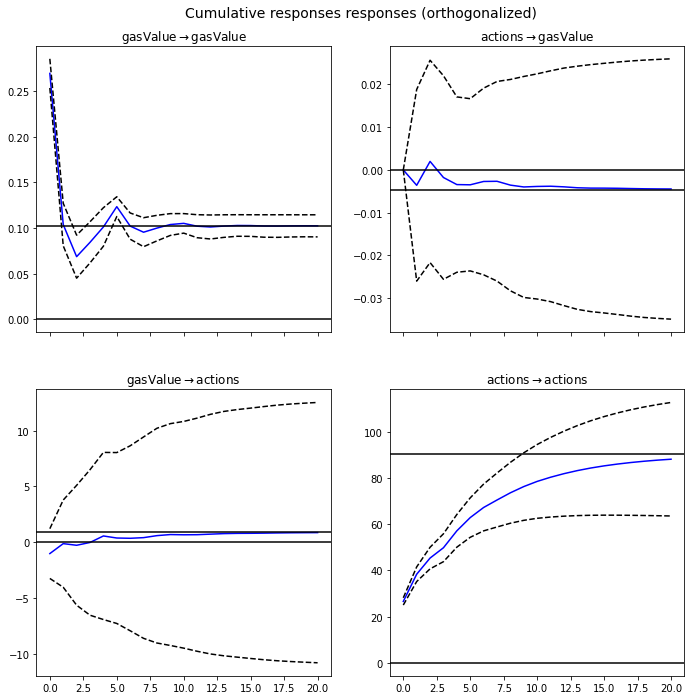

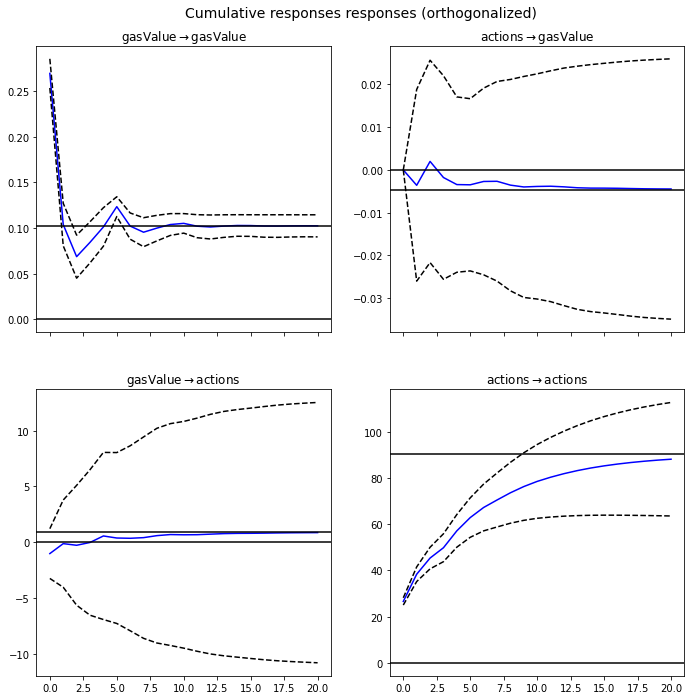

In [46]:
irf1.plot_cum_effects(orth=True)

In [47]:
results1.fevd(periods=20).summary()

FEVD for gasValue
      gasValue   actions
0     1.000000  0.000000
1     0.999871  0.000129
2     0.999565  0.000435
3     0.999426  0.000574
4     0.999401  0.000599
5     0.999404  0.000596
6     0.999401  0.000599
7     0.999401  0.000599
8     0.999393  0.000607
9     0.999392  0.000608
10    0.999392  0.000608
11    0.999392  0.000608
12    0.999391  0.000609
13    0.999391  0.000609
14    0.999391  0.000609
15    0.999391  0.000609
16    0.999391  0.000609
17    0.999391  0.000609
18    0.999391  0.000609
19    0.999391  0.000609

FEVD for actions
      gasValue   actions
0     0.001486  0.998514
1     0.002179  0.997821
2     0.002083  0.997917
3     0.002107  0.997893
4     0.002339  0.997661
5     0.002296  0.997704
6     0.002254  0.997746
7     0.002234  0.997766
8     0.002244  0.997756
9     0.002238  0.997762
10    0.002227  0.997773
11    0.002221  0.997779
12    0.002218  0.997782
13    0.002216  0.997784
14    0.002214  0.997786
15    0.002212  0.997788
16    0.002211

In [48]:
results1.test_normality().summary()

Test statistic,Critical value,p-value,df
7.543e+04,9.488,0.000,4


In [49]:
results1.test_whiteness(nlags=20).summary()

Test statistic,Critical value,p-value,df
71.80,83.68,0.235,64


In [50]:
results1.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
0.8101,3.841,0.368,1


In [51]:
results1.test_causality(caused='actions',causing='gasValue').summary()

Test statistic,Critical value,p-value,df
0.5494,2.380,0.699,"(4, 1074)"


## Slice 2

In [52]:
slice2: pd.DataFrame = gas_slice2.copy(deep=True)
slice2['actions'] = aragon_slice2['actions'].tolist()

In [53]:
model2 = sm.tsa.VAR(slice2)
model2.select_order(10).summary()

/home/youss/Documentos/gas-dao-activity/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,5.070,5.103,159.2,5.084
1,4.916,5.014,136.5,4.956
2,4.820*,4.983*,124.0*,4.886*
3,4.827,5.055,124.8,4.919
4,4.842,5.136,126.8,4.961
5,4.861,5.220,129.2,5.007
6,4.893,5.318,133.4,5.065
7,4.906,5.395,135.1,5.104
8,4.911,5.466,135.9,5.136
9,4.920,5.540,137.2,5.171


In [54]:
results2 = model2.fit(maxlags=2, ic='bic')
results2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Jan, 2021
Time:                     13:04:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    4.92857
Nobs:                     211.000    HQIC:                   4.83393
Log likelihood:          -1092.00    FPE:                    117.888
AIC:                      4.76972    Det(Omega_mle):         112.494
--------------------------------------------------------------------
Results for equation gasValue
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.051058         0.049100            1.040           0.298
L1.gasValue        -0.152281         0.066416           -2.293           0.022
L1.actions         -0.000153         0.000795           -0.193   

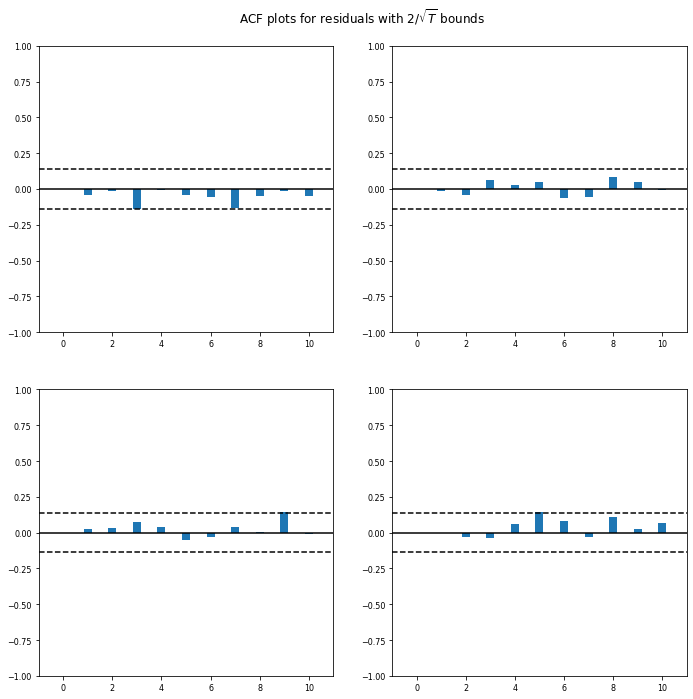

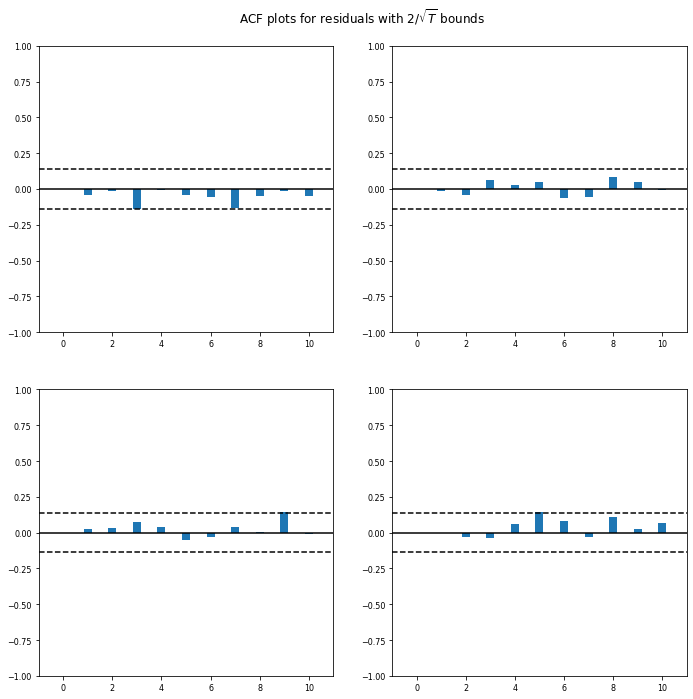

In [55]:
results2.plot_acorr()

### Impulse Response

In [56]:
irf2 = results2.irf(20)

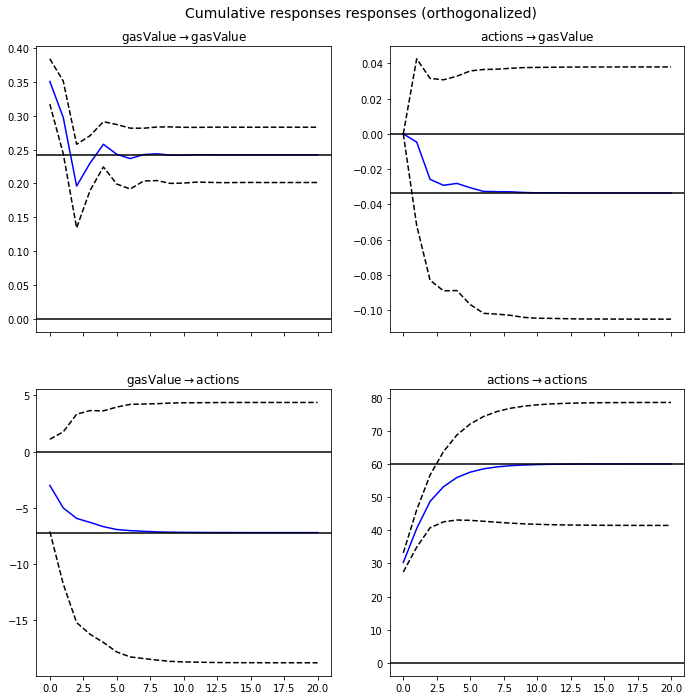

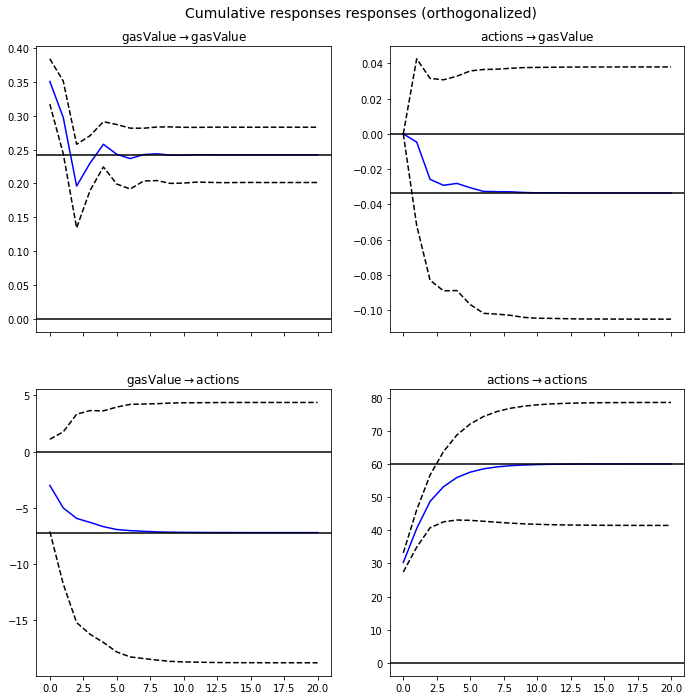

In [57]:
irf2.plot_cum_effects(orth=True)

In [58]:
results2.fevd(periods=20).summary()

FEVD for gasValue
      gasValue   actions
0     1.000000  0.000000
1     0.999828  0.000172
2     0.996574  0.003426
3     0.996518  0.003482
4     0.996529  0.003471
5     0.996491  0.003509
6     0.996461  0.003539
7     0.996462  0.003538
8     0.996462  0.003538
9     0.996461  0.003539
10    0.996460  0.003540
11    0.996460  0.003540
12    0.996460  0.003540
13    0.996460  0.003540
14    0.996460  0.003540
15    0.996460  0.003540
16    0.996460  0.003540
17    0.996460  0.003540
18    0.996460  0.003540
19    0.996460  0.003540

FEVD for actions
      gasValue   actions
0     0.009785  0.990215
1     0.012622  0.987378
2     0.012634  0.987366
3     0.012524  0.987476
4     0.012563  0.987437
5     0.012590  0.987410
6     0.012588  0.987412
7     0.012587  0.987413
8     0.012588  0.987412
9     0.012588  0.987412
10    0.012588  0.987412
11    0.012588  0.987412
12    0.012588  0.987412
13    0.012588  0.987412
14    0.012588  0.987412
15    0.012588  0.987412
16    0.012588

In [59]:
results2.test_normality().summary()

Test statistic,Critical value,p-value,df
2846.,9.488,0.000,4


In [60]:
results2.test_whiteness(nlags=20).summary()

Test statistic,Critical value,p-value,df
63.99,92.81,0.738,72


In [61]:
results2.test_inst_causality(causing='gasValue').summary()

Test statistic,Critical value,p-value,df
2.045,3.841,0.153,1


In [62]:
results2.test_causality(caused='actions',causing='gasValue').summary()

Test statistic,Critical value,p-value,df
0.1223,3.018,0.885,"(2, 412)"
